In [2]:
import numpy as np
def source_function( x, y ):
    if ( x >= 0.1 and x <= 0.3 and y >= 0.1 and y <= 0.3 ):
        return 1.0
    else:
        return 0.0

np_source_function = np.vectorize(source_function)

In [3]:
def indexFD(i, j, n):
  k = ( i*n + j )
  return k

def reverseIndexFD(k, n):
    i = k // n
    j = k % n
    return i, j

In [4]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

In [5]:
import scipy as sp
import numpy as np

def diffusionMatrix( mux, muy, h ):
  n = int(1./h + 1)
  N = n**2
  A = sp.sparse.lil_array((N, N), dtype=np.float64)

  # Pass through all grid points and apply local stencil

  stencil = np.array([(mux+muy)*2., -mux*1., -mux*1., -muy*1., -muy*1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import inspect
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def diffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.csc_array((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]
  u0_int = u0[intNodes]

 
  res = []

  def iterate_count(x):
    iterate_count.iterate_counts += 1
    frame = inspect.currentframe().f_back
    res.append(frame.f_locals['resid'])


  iterate_count.iterate_counts = 0
  

  f[intNodes], info = sp.sparse.linalg.cg(A_int, F_int, x0=None, tol=tol, maxiter=maxiter, M=M, callback=iterate_count, atol=None)
  print(f'Exit code: {info}')
  print(f'Number of iterations: {iterate_count.iterate_counts}')

  f[extNodes] = u0[extNodes]
  fig, ax = plt.subplots()
  ax.plot(res)
  ax.set_title('Residuals of CCG')
  ax.set_yscale('log')
  ax.set_xlabel('Iteration i')
  ax.set_ylabel('Residual')
  plt.show()
  print(f'End residual: {res[-1]}')


  return f.toarray()


/usr/lib/python3/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Exit code: 0
Number of iterations: 133


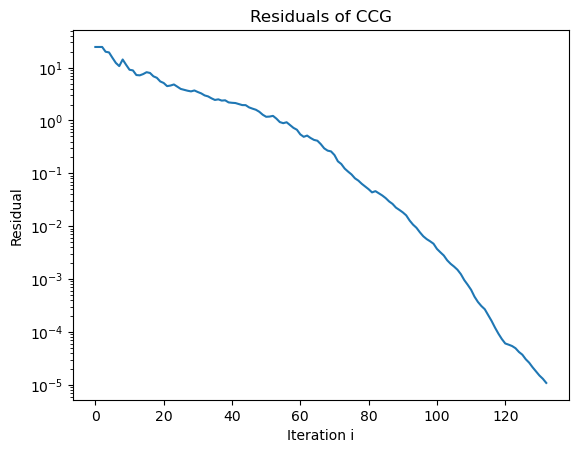

End residual: 1.084633612183622e-05


In [7]:
h = 0.02
mux = 1
muy = 1
solgrad = diffusionGradSolver(mux, muy, h, 1e-6, 1000, None)

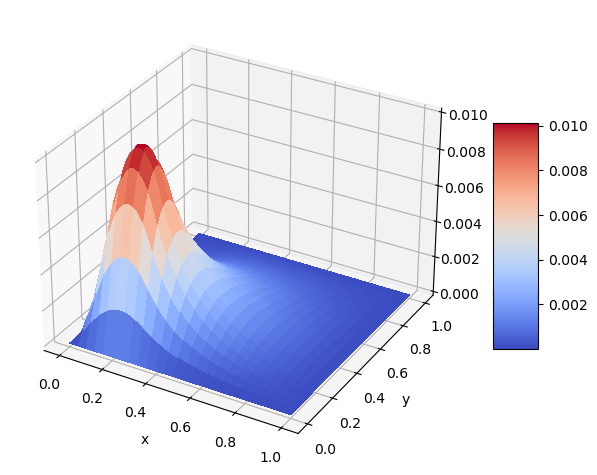

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.0, 0.01)
fig.tight_layout(pad=1.0)
plt.xlabel('x')
plt.ylabel('y')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

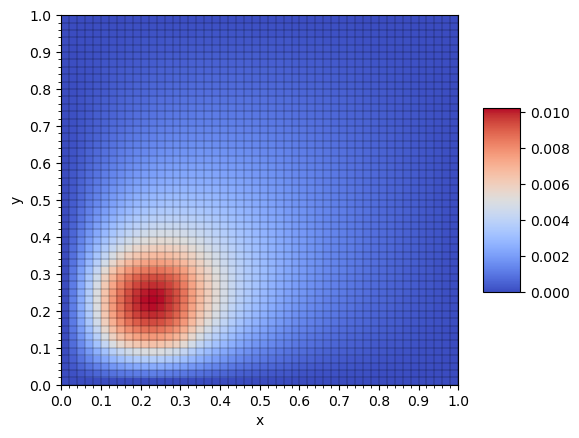

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
#rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=0.5, edgecolor='k', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)
plt.xlabel('x')
plt.ylabel('y')

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

(d) myPCG Implementation

In [10]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt


def myPCG( A, b, L, U, tol, maxit ):
    # A:       Matrix produced by diffusionMatrix
    # b:       RHS calculated by the source function
    # L and U: factors of the preconditioner from sp.spilu
    # tol:     tolerance for convergence
    # maxit:   maximum number of iterations

    # Initialize parameters
    M = (L @ U)
    x = np.zeros_like(b)  # Initial guess
    r0 = b - (A@x)  # Initial residual
    z0 = sp.sparse.linalg.spsolve(M,r0)  # Apply preconditioner
    d0 = z0.copy()
    i=0
    res=[]

    #PCG Loop
    while i < maxit:
        alpha = (r0.T @ z0) / (d0.T @ A @ d0)
        x += alpha * d0
        r1 = r0 - alpha * (A @ d0)
        #norm = np.linalg.norm(r1,2)
        norm = np.dot(r1, r1)
        #norm = np.linalg.norm(alpha*d0,2)
        res.append(norm)
        # Check for convergence
        if norm < tol:
            break

        z1 = sp.sparse.linalg.spsolve(M,r1)
        beta = (r1.T @ z1) / (r0.T @ z0)
        d0 = z1 + beta * d0
        r0, z0 = r1, z1
        i += 1

    #Plot the residual
    fig, ax = plt.subplots()
    ax.plot(res)
    ax.set_title('Residuals of PCG')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration i')
    ax.set_ylabel('Residual')
    plt.show()
    print(f'End residual: {res[-1]}')

    print(f"Number of iterations = {i}, Norm = {norm}")

    return x, res

In [11]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt

def myPCGSolver(mux, muy, h, tol, maxit, drop_tol):
    n = int(1./h + 1)
    N = n**2
    intNodes, extNodes = boundaryConditions(n)
    res = []
    # Generate diffusion matrix
    A = diffusionMatrix(mux, muy, h)
    A_int = A[intNodes][:, intNodes]
    
    # Create ILU preconditioner using scipy
    M = sp.sparse.linalg.spilu(A_int, drop_tol=drop_tol)
    L = M.L
    U = M.U

    print(f'Number of nonzero elements in L: {L.nnz}')
    print(f'Number of nonzero elements in U: {U.nnz}')
    print(f'{(1-(L.nnz+U.nnz)/(N*N) )*100:.2f}% Sparsity')
    
    # Define source term and initialize vectors
    b = np.zeros(N, dtype=np.float64)
    for k in range (0,N):
        i, j = reverseIndexFD(k, n)
        b[k] = source_function( i*h, j*h )
    b_int = b[intNodes]

    sol = np.zeros_like(b)
    sol[intNodes], res = myPCG(A_int,b_int,L,U,tol,maxit)
    return sol, res


Exit code: 0
Number of iterations: 133


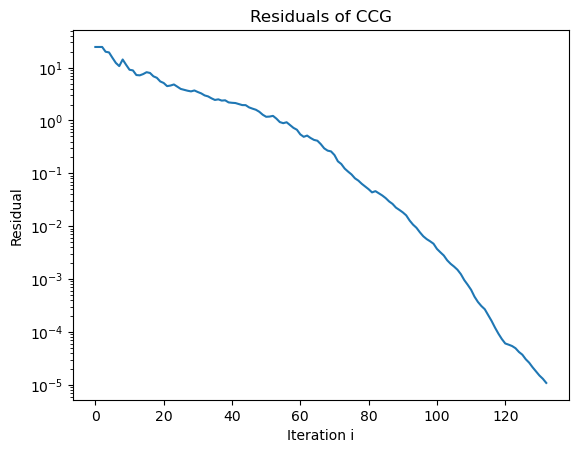

End residual: 1.084633612183622e-05
Number of nonzero elements in L: 15985
Number of nonzero elements in U: 9692
99.62% Sparsity


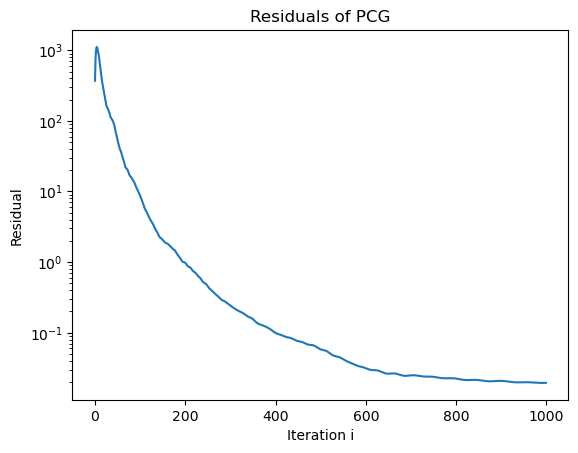

End residual: 0.019473455357652308
Number of iterations = 1000, Norm = 0.019473455357652308


In [12]:
import time

h = 0.02
mux = 1.0
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1

solcg = diffusionGradSolver(mux, muy, h, tol, maxit, None)
solpcg, res = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)



Challenges with ILU preconditioned CG algorith:
- Convergence isn't reached with a drop off value of 0.1 for grid spacing less than ~0.05. Residual plateaus.
- We have not been given an h value - perhaps we are only supposed to use a large h value?
- If the drop off value is larger, then convergence is achieved.

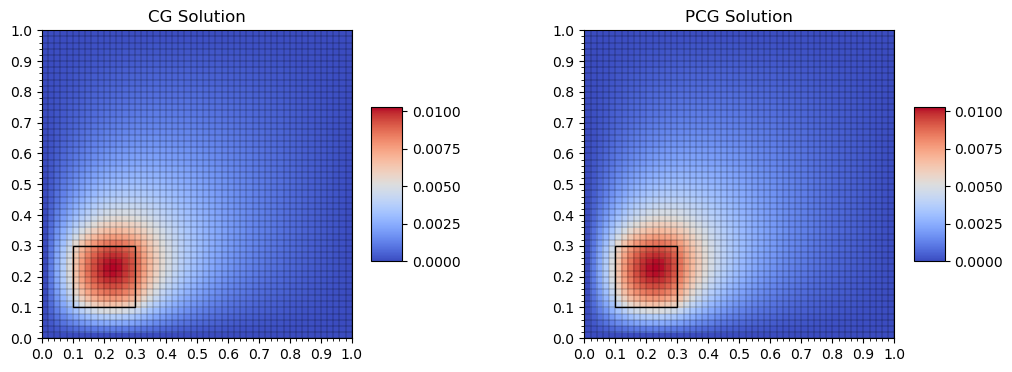

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Increase the figure size to make the plot area wider
ax1 = axs[0]
ax2 = axs[1]

fig.subplots_adjust(wspace=0.4)  # Increase the padding between subplots

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z1 = solcg.reshape(int(1./h+1),int(1./h+1))
Z2 = solpcg.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf1 = ax1.pcolor(X, Y, Z1[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.pcolor(X, Y, Z2[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch for ax1
rect1 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Create a Rectangle patch for ax2
rect2 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect1)
ax2.add_patch(rect2)

# Add a grid to ax1
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))

# Add a color bar which maps values to colors.
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

hx = 0.1
# Add a grid
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))
ax1.set_title('CG Solution')

ax2.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.minorticks_on()
ax2.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.set_xticks(np.arange(0., 1.+hx, hx))
ax2.set_yticks(np.arange(0., 1.+hx, hx))
ax2.set_title('PCG Solution')

plt.show()

(f) Compare the results for varying $\mu_x$

Number of nonzero elements in L: 15985
Number of nonzero elements in U: 9692
99.62% Sparsity


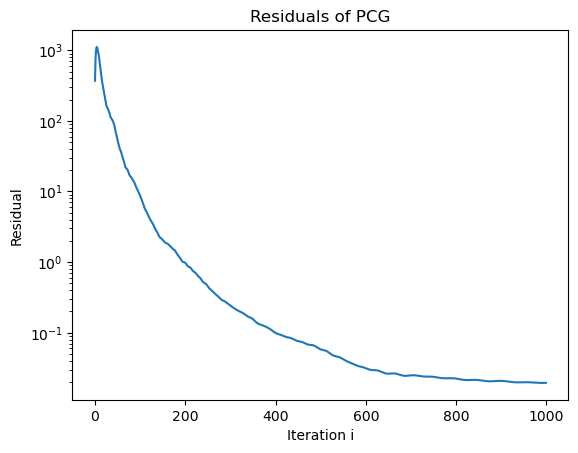

End residual: 0.019473455357652308
Number of iterations = 1000, Norm = 0.019473455357652308
Number of nonzero elements in L: 12859
Number of nonzero elements in U: 7862
99.69% Sparsity


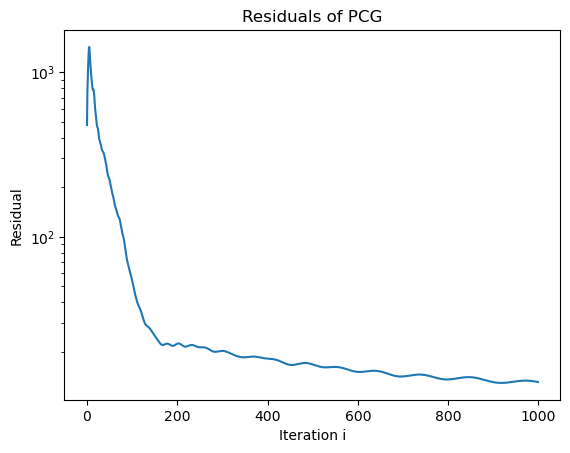

End residual: 13.138914076884882
Number of iterations = 1000, Norm = 13.138914076884882
Number of nonzero elements in L: 11529
Number of nonzero elements in U: 7578
99.72% Sparsity


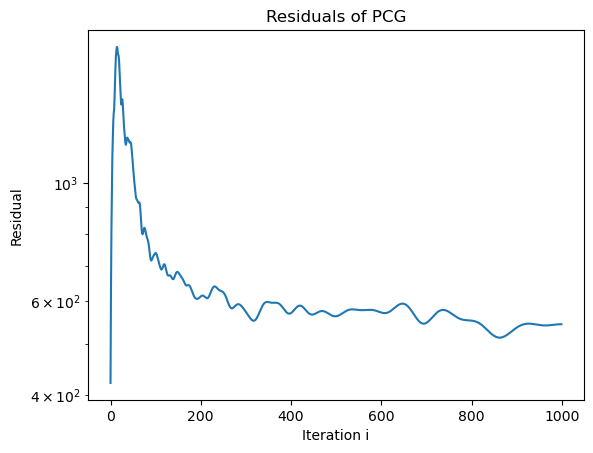

End residual: 543.5291482643647
Number of iterations = 1000, Norm = 543.5291482643647


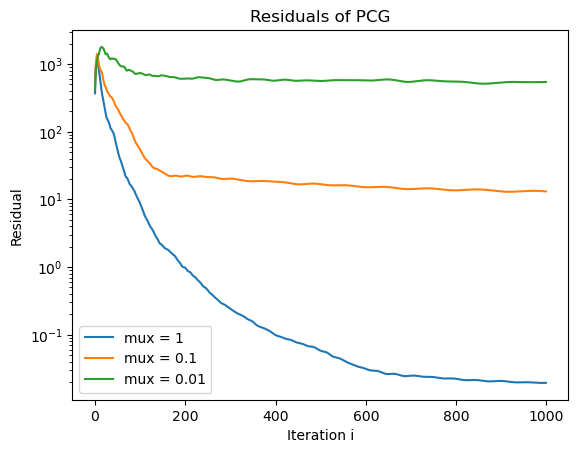

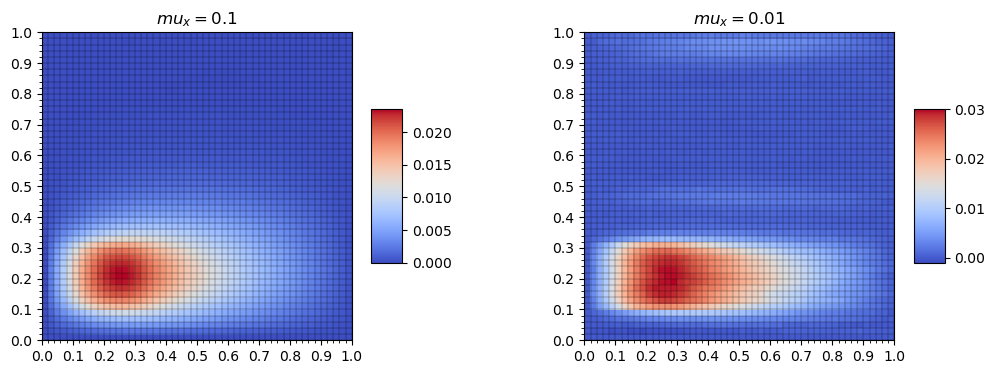

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches


h = 0.02
mux = 1
mux0 = 0.1
mux1 = 0.01
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1

solpcg, res = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)
solpcg0, res0 = myPCGSolver(mux0,muy,h,tol,maxit,drop_tol)
solpcg1, res1 = myPCGSolver(mux1,muy,h,tol,maxit,drop_tol)

fig, ax = plt.subplots()
ax.plot(res)
ax.plot(res0)
ax.plot(res1)
ax.legend(['mux = 1', 'mux = 0.1', 'mux = 0.01'])
ax.set_title('Residuals of PCG')
ax.set_yscale('log')
ax.set_xlabel('Iteration i')
ax.set_ylabel('Residual')
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Increase the figure size to make the plot area wider
ax1 = axs[0]
ax2 = axs[1]

fig.subplots_adjust(wspace=0.4)  # Increase the padding between subplots

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z1 = solpcg0.reshape(int(1./h+1),int(1./h+1))
Z2 = solpcg1.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf1 = ax1.pcolor(X, Y, Z1[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.pcolor(X, Y, Z2[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch for ax1
#rect1 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Create a Rectangle patch for ax2
#rect2 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
#ax1.add_patch(rect1)
#ax2.add_patch(rect2)

# Add a grid to ax1
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))

# Add a color bar which maps values to colors.
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

hx = 0.1
# Add a grid
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))
ax1.set_title('$mu_x = 0.1$')

ax2.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.minorticks_on()
ax2.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.set_xticks(np.arange(0., 1.+hx, hx))
ax2.set_yticks(np.arange(0., 1.+hx, hx))
ax2.set_title('$mu_x = 0.01$')

plt.show()



Custom CG solver

In [15]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt


def myCG( A, b, tol, maxit ):
    # A:       Matrix produced by diffusionMatrix
    # b:       RHS calculated by the source function
    # L and U: factors of the preconditioner from sp.spilu
    # tol:     tolerance for convergence
    # maxit:   maximum number of iterations

    # Initialize parameters
    x = np.zeros_like(b)  # Initial guess
    r0 = b - (A@x)  # Initial residual
    d0 = r0.copy()
    i=0
    res=[]

    #PCG Loop
    while i < maxit:
        alpha = (r0.T @ r0) / (d0.T @ A @ d0)
        x += alpha * d0
        r1 = r0 - alpha * (A @ d0)
        norm = np.linalg.norm(r1,2)
        res.append(norm)
        # Check for convergence
        if norm < tol:
            break

        beta = (r1.T @ r1) / (r0.T @ r0)
        d0 = r1 + beta * d0
        r0 = r1
        i += 1

    #Plot the residual
    fig, ax = plt.subplots()
    ax.plot(res)
    ax.set_title('Residuals of PCG')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration i')
    ax.set_ylabel('Residual')
    plt.show()
    print(f'End residual: {res[-1]}')

    print(f"Number of iterations = {i}, Norm = {norm}")

    return x, res

In [16]:
import inspect
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def mydiffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.csc_array((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]
  u0_int = u0[intNodes]

  res = []

  f[intNodes], res = myCG(A_int, F_int, tol=tol, maxit=maxiter)
  f[extNodes] = u0[extNodes]

  return f.toarray()


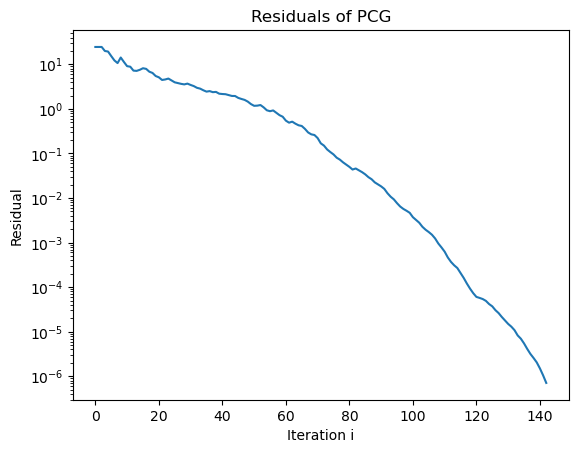

End residual: 7.092687229264858e-07
Number of iterations = 142, Norm = 7.092687229264858e-07


In [17]:
h = 0.02
mux = 1
muy = 1
solgrad = mydiffusionGradSolver(mux, muy, h, 1e-6, 1000, None)

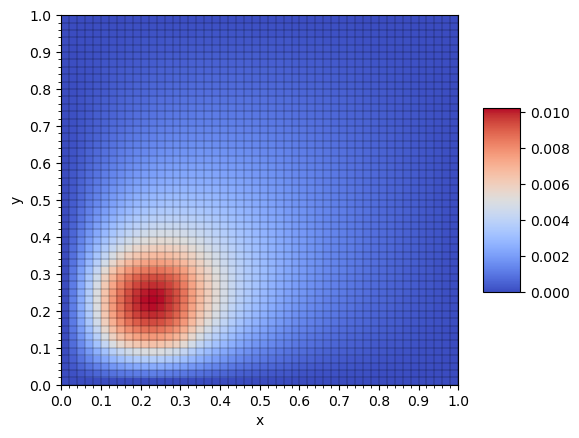

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
#rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=0.5, edgecolor='k', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)
plt.xlabel('x')
plt.ylabel('y')

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

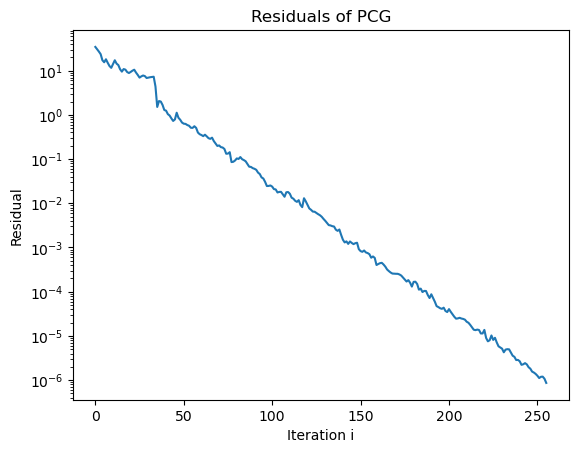

End residual: 8.643724345121057e-07
Number of iterations = 255, Norm = 8.643724345121057e-07
Time for CG: 0.6497254371643066
Number of nonzero elements in L: 11529
Number of nonzero elements in U: 7578
99.72% Sparsity


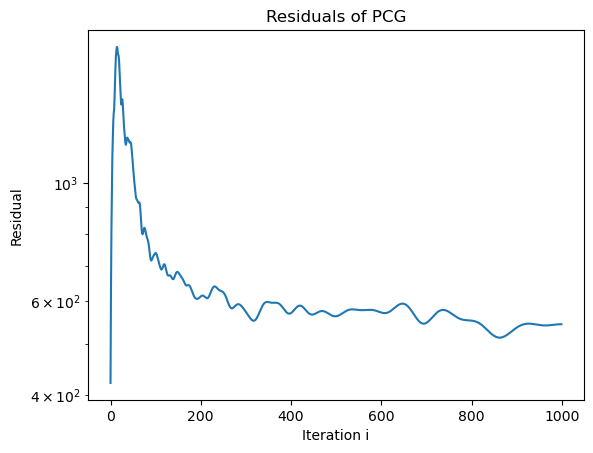

End residual: 543.5291482643647
Number of iterations = 1000, Norm = 543.5291482643647
Time for PCG: 5.839041471481323


In [19]:
import time

h = 0.02
mux = 0.01
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1

start = time.time()
solcg = mydiffusionGradSolver(mux, muy, h, tol, maxit, None)
print(f'Time for CG: {time.time()-start}')

start = time.time()
solpcg, res = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)
print(f'Time for PCG: {time.time()-start}')


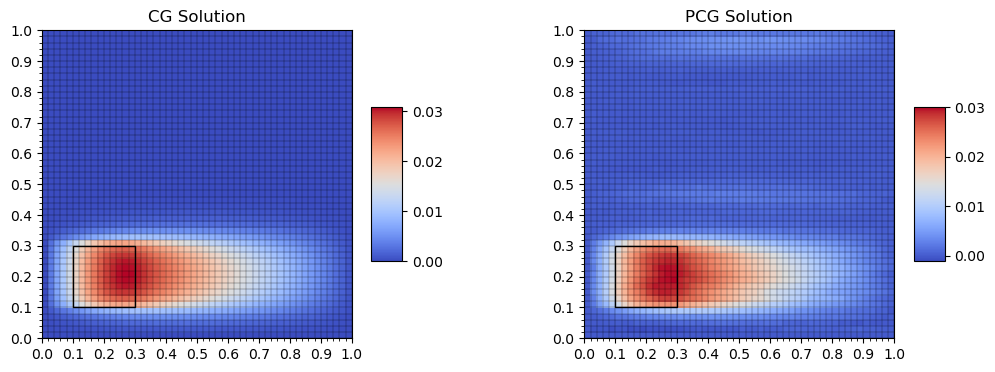

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Increase the figure size to make the plot area wider
ax1 = axs[0]
ax2 = axs[1]

fig.subplots_adjust(wspace=0.4)  # Increase the padding between subplots

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z1 = solcg.reshape(int(1./h+1),int(1./h+1))
Z2 = solpcg.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf1 = ax1.pcolor(X, Y, Z1[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.pcolor(X, Y, Z2[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch for ax1
rect1 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Create a Rectangle patch for ax2
rect2 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect1)
ax2.add_patch(rect2)

# Add a grid to ax1
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))

# Add a color bar which maps values to colors.
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

hx = 0.1
# Add a grid
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))
ax1.set_title('CG Solution')

ax2.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.minorticks_on()
ax2.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.set_xticks(np.arange(0., 1.+hx, hx))
ax2.set_yticks(np.arange(0., 1.+hx, hx))
ax2.set_title('PCG Solution')

plt.show()